In [1]:
import pandas as pd
import numpy as np
import polars as pl
import polars.selectors as cs
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
classification_report,roc_auc_score, roc_curve, confusion_matrix, f1_score
)
from sklearn.manifold import TSNE

import umap
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchviz import make_dot
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore') 

In [2]:
%run -i "EDA_utils.py"

In [3]:
df = pd.read_csv("./creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
pl_df= pl.from_dataframe(df)
pl_df.shape

(284807, 31)

In [5]:
pl_df.schema

Schema([('Time', Float64),
        ('V1', Float64),
        ('V2', Float64),
        ('V3', Float64),
        ('V4', Float64),
        ('V5', Float64),
        ('V6', Float64),
        ('V7', Float64),
        ('V8', Float64),
        ('V9', Float64),
        ('V10', Float64),
        ('V11', Float64),
        ('V12', Float64),
        ('V13', Float64),
        ('V14', Float64),
        ('V15', Float64),
        ('V16', Float64),
        ('V17', Float64),
        ('V18', Float64),
        ('V19', Float64),
        ('V20', Float64),
        ('V21', Float64),
        ('V22', Float64),
        ('V23', Float64),
        ('V24', Float64),
        ('V25', Float64),
        ('V26', Float64),
        ('V27', Float64),
        ('V28', Float64),
        ('Amount', Float64),
        ('Class', Int64)])

In [6]:
pl_df.describe()

statistic,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",94813.859575,1.1307e-15,3.6644e-16,-1.3449e-15,2.0458e-15,1.0307e-15,1.4924e-15,-5.9047e-16,8.7818e-17,-2.3695e-15,2.2651e-15,1.6655e-15,-1.2339e-15,8.0649e-16,1.1793e-15,4.8866e-15,1.4697e-15,-3.9748e-16,9.2533e-16,1.0161e-15,6.5863e-16,1.8043e-16,-3.2952e-16,2.3222e-16,4.4567e-15,4.9697e-16,1.7068e-15,-3.5062e-16,-1.1137e-16,88.349619,0.001727
"""std""",47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.08885,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.62446,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
"""min""",0.0,-56.40751,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.49772,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.0,0.0
"""25%""",54202.0,-0.920372,-0.598545,-0.890358,-0.848637,-0.691592,-0.768295,-0.554068,-0.208628,-0.643096,-0.535425,-0.762491,-0.405566,-0.648535,-0.425561,-0.582882,-0.468018,-0.483745,-0.49885,-0.456291,-0.211721,-0.22839,-0.542348,-0.161846,-0.354579,-0.317143,-0.326979,-0.070839,-0.052959,5.6,0.0
"""50%""",84692.0,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.02945,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.0,0.0
"""75%""",139321.0,1.315648,0.803728,1.027201,0.743354,0.611927,0.398569,0.570446,0.327346,0.59714,0.453945,0.739596,0.61824,0.662507,0.49315,0.648823,0.523303,0.399677,0.50081,0.458951,0.133047,0.186384,0.528555,0.147642,0.439527,0.350716,0.240957,0.091046,0.078281,77.17,0.0
"""max""",172792.0,2.45493,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.50309,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.16,1.0


- There are no missing values to handle. 

let's see the distribution of the target value:

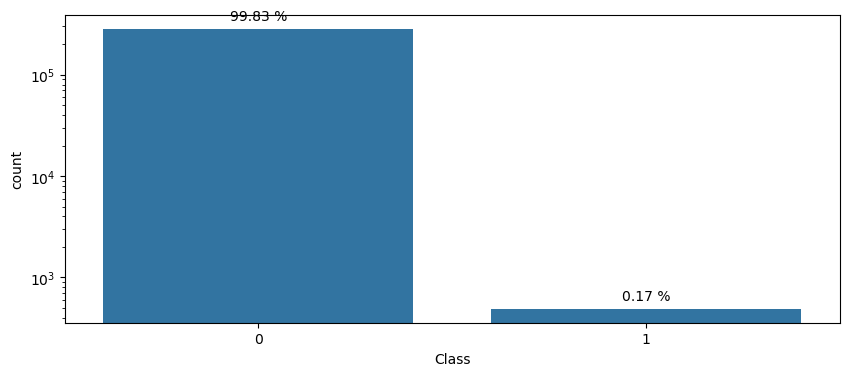

In [7]:
pl_barplot("Class",pl_df, x_rot=0)

In [8]:
pl_valueCounts_perc("Class",pl_df)

Class,count,percentage %
i64,u32,f64
0,284315,99.83
1,492,0.17


- We have a highly imbalanced data, i.e., only 0.17% of transaction are fraudulent. 
- Since the minority class is rare, we can use autoencoders for anomaly detection (distinguishing fraud from non fraud)!

# Modeling
- The goal is to traind the autoencoder on the majority class (normal/non-fradulent transactions) only so that it can detect anomalous/ fraud transactions (minority class). 
- Why this works well with imbalanced data?
    - You don’t need to balance the classes.
    - You’re not modeling the minority class directly (which is sparse and hard to learn).
    - You're using a generative approach (learn what “normal” looks like and detect deviations).

In [9]:
# features
X= df.drop(["Class","Time"], axis=1)
input_dim = X.shape[1]
# target
y = df["Class"]

# non-fraud
X_normal= X[y == 0]
y_normal= y[y == 0]
# fraud
X_fraud= X[y == 1]
y_fraud= y[y == 1]

In [10]:
# Train only on majority class (0)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normal, y_normal, test_size=0.2, random_state=42
)
X_val, X_test_normal, y_val, y_test_normal= train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42)


# # Train only on majority class (0)
# X_train, X_test_normal, y_train, y_test_normal = train_test_split(
#     X_normal, y_normal, test_size=0.2, random_state=42
# )

# create the test set from all fraud+ remaining non-fraud
X_test= pd.concat([X_test_normal, X_fraud], axis=0)
y_test= pd.concat([y_test_normal, y_fraud], axis=0)

print(f" Training set dim: {X_train.shape}")
print(f" Eval set dim: {X_val.shape}")
print(f" Tets set dim: {X_test.shape}")

 Training set dim: (227452, 29)
 Eval set dim: (45490, 29)
 Tets set dim: (11865, 29)


In [11]:
# log transform
pt = PowerTransformer(method='yeo-johnson')
X_train["Amount"] = pt.fit_transform(X_train[["Amount"]])
X_val["Amount"] = pt.transform(X_val[["Amount"]])
X_test["Amount"] = pt.transform(X_test[["Amount"]])

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.int64)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.int64)

train_loader = DataLoader(
    TensorDataset(X_train_tensor,y_train_tensor), 
    batch_size=64, shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_val_tensor,y_val_tensor), 
    batch_size=64, shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor), 
    batch_size=64, shuffle=False
)

In [12]:
# 3. Define Autoencoder model
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            # nn.Linear(4, 2),
            # nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # nn.Linear(2, 4),
            # nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
        )

    def forward(self, x):
        # latent
        encoded = self.encoder(x)
        # reconstructed
        decoded = self.decoder(encoded)
        return decoded

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# 4. Initialize model
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 5

model = AutoEncoder(input_dim=X_train.shape[1]).to(device)
print(model)
# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Initialize the loss function
loss_fn = nn.MSELoss()

Using cuda device
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=29, bias=True)
    (1): ReLU()
    (2): Linear(in_features=29, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=29, bias=True)
  )
)


### Generate a computational graph of the autoencoder

In [25]:
summary(model, input_size=X_train.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 227452, 29]             870
              ReLU-2           [-1, 227452, 29]               0
            Linear-3           [-1, 227452, 16]             480
              ReLU-4           [-1, 227452, 16]               0
            Linear-5            [-1, 227452, 8]             136
              ReLU-6            [-1, 227452, 8]               0
            Linear-7            [-1, 227452, 4]              36
              ReLU-8            [-1, 227452, 4]               0
            Linear-9            [-1, 227452, 8]              40
             ReLU-10            [-1, 227452, 8]               0
           Linear-11           [-1, 227452, 16]             144
             ReLU-12           [-1, 227452, 16]               0
           Linear-13           [-1, 227452, 29]             493
Total params: 2,199
Trainable params: 2

In [16]:
# x = train_loader.dataset[0][0]
# y = model(x.to(device))

# make_dot(y.mean(), params=dict(model.named_parameters())).render("autoencoder_architecture", format="png")

'autoencoder_architecture.png'

In [14]:
# # Training loop
# def train_loop(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader.dataset)
#     model.train()
#     for batch, (X,y) in enumerate(dataloader):
#         X, y = X.to(device), y.to(device)
#         # compute prediction and loss
#         X_reconstructed = model(X)
#         loss = loss_fn(X_reconstructed, X)
#         # Zero gradients, perform a backward pass, and update the weights
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if batch % 1000 == 0:
#             loss, current = loss.item(), batch * BATCH_SIZE + len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# def test_loop(dataloader, model, loss_fn):
#     model.eval()
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     test_loss= 0

#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device), y.to(device)
#             X_reconstructed = model(X)
#             test_loss += loss_fn(X_reconstructed, X).item()

#     test_loss /= num_batches
#     print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [26]:
trainingEpoch_loss = []
valEpoch_loss = []

# def train(train_loader,test_loader,optimizer,loss_fn,model,num_epochs):
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    #-------------------
    # train
    #-------------------
    train_size = len(train_loader.dataset)
    model.train()
    train_batch_loss= []
    for batch, (X,y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        # compute prediction and loss
        X_reconstructed = model(X)
        loss = loss_fn(X_reconstructed, X)
        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # batch loss
        train_batch_loss.append(loss.item())
        if batch % 1000 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{train_size:>5d}]")
    trainingEpoch_loss.append(np.array(train_batch_loss).mean())

    #-----------------
    # validate
    #-----------------
    model.eval()
    # size = len(dataloader.dataset)
    num_batches = len(val_loader)
    val_loss= 0

    with torch.no_grad():
        val_batch_loss= []
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            # compute prediction and loss
            X_reconstructed = model(X)
            loss_val = loss_fn(X_reconstructed, X).item()
            val_loss += loss_val
            val_batch_loss.append(loss_val)
    valEpoch_loss.append(np.array(val_batch_loss).mean())
    val_loss /= num_batches
    print(f"Val Error: \n Avg loss: {val_loss:>8f} \n")


Epoch 1
-------------------------------
loss: 1.357417  [   64/227452]
loss: 0.621425  [64064/227452]
loss: 0.732252  [128064/227452]
loss: 1.246408  [192064/227452]
Val Error: 
 Avg loss: 0.748190 

Epoch 2
-------------------------------
loss: 0.826906  [   64/227452]
loss: 0.666733  [64064/227452]
loss: 0.693901  [128064/227452]
loss: 0.481579  [192064/227452]
Val Error: 
 Avg loss: 0.677667 

Epoch 3
-------------------------------
loss: 0.625058  [   64/227452]
loss: 0.583698  [64064/227452]
loss: 0.526740  [128064/227452]
loss: 0.922483  [192064/227452]
Val Error: 
 Avg loss: 0.645003 

Epoch 4
-------------------------------
loss: 0.465402  [   64/227452]
loss: 0.678112  [64064/227452]
loss: 0.699545  [128064/227452]
loss: 0.430150  [192064/227452]
Val Error: 
 Avg loss: 0.622964 

Epoch 5
-------------------------------
loss: 0.634242  [   64/227452]
loss: 0.672372  [64064/227452]
loss: 0.725200  [128064/227452]
loss: 0.588764  [192064/227452]
Val Error: 
 Avg loss: 0.607275 



<function matplotlib.pyplot.show(close=None, block=None)>

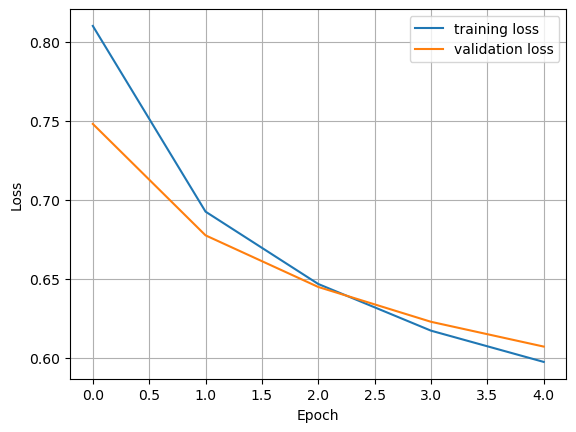

In [32]:
plt.plot(trainingEpoch_loss, label='training loss')
plt.plot(valEpoch_loss, label='validation loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show

# Anomaly detection using the reconstruction error
- Fraudulent transactions will then be detected as anomalies using reconstruction error. The idea here is that those fradulent transactions should produce higher reconstruction errors compared to the normal transactions as the model has learned to reconstruct “normal” behavior effectively. The process is as follows:
    - We get a reconstruction error for every test sample.
    - If the reconstruction error > chosen threshold → mark as fraud (1) otherwise → mark as normal (0).
- Note that the threshold we choose here critically affect the performance of our model.

In [17]:
# anomaly detection
model.eval()
reconstruction_errors = []
actual_labels = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        X_reconstructed = model(X)
        test_loss = torch.mean((X_reconstructed - X) ** 2, dim=1)
        reconstruction_errors.extend(test_loss.cpu().numpy())
        actual_labels.extend(y.cpu().numpy())

In [18]:
# Convert the lists into NumPy arrays
reconstruction_errors= np.array(reconstruction_errors)
actual_labels= np.array(actual_labels)

# Choose a threshold using a percentile (e.g., the 95th percentile)
threshold = np.percentile(reconstruction_errors[actual_labels==0], 95)  # adjust as needed
print(f"Anomaly threshold using the 95th percentile: {threshold:.4f}")

# predict class label
predictions = (reconstruction_errors > threshold).astype(int)

Anomaly threshold using the 95th percentile: 1.2894


## Evaluation


Classification Report (Autoencoder-based Anomaly Detection):
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97     11373
       Fraud       0.42      0.85      0.56       492

    accuracy                           0.95     11865
   macro avg       0.71      0.90      0.77     11865
weighted avg       0.97      0.95      0.95     11865



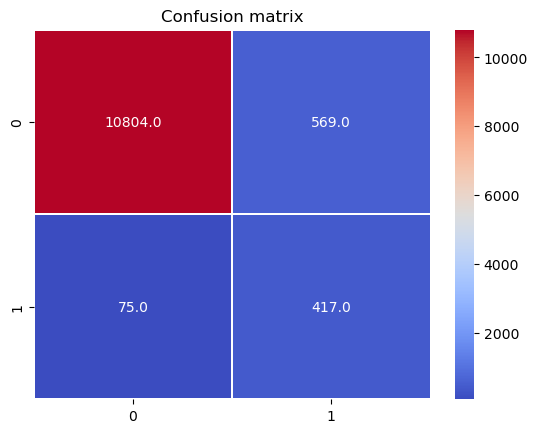

In [19]:
print("\nClassification Report (Autoencoder-based Anomaly Detection):")
print(classification_report(actual_labels, predictions, target_names=["Normal", "Fraud"]))

sns.heatmap(
    confusion_matrix(actual_labels, predictions),
    linewidths=.12,
    cmap="coolwarm",
    annot=True,
    fmt=".1f"
)
plt.title("Confusion matrix")
plt.show()

## Reconstruction Error Distribution

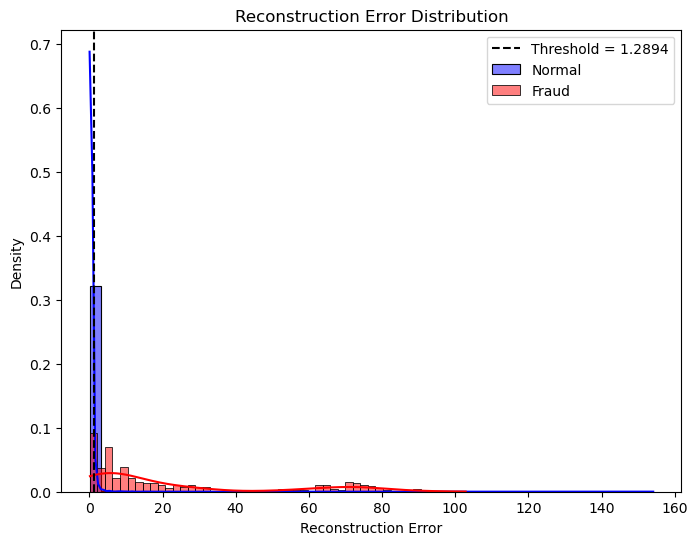

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(reconstruction_errors[actual_labels == 0], bins=50, label="Normal", color='blue', stat='density', kde=True)
sns.histplot(reconstruction_errors[actual_labels == 1], bins=50, label="Fraud", color='red', stat='density', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend()
plt.show()

## ROC AUC curve

#### Find the threshold that maximizes the difference between True Positive Rate (TPR) and False Positive Rate (FPR) 

In [21]:
# Get ROC curve values
fpr, tpr, thresholds = roc_curve(actual_labels, reconstruction_errors)

# Find optimal threshold: maximize TPR - FPR
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Threshould maximizing TPR - FPR: {optimal_threshold}")
# Use threshold from ROC curve
predictions = (reconstruction_errors > optimal_threshold).astype(int)

Threshould maximizing TPR - FPR: 2.038147449493408


Optimal Threshold based on ROC: 2.038147


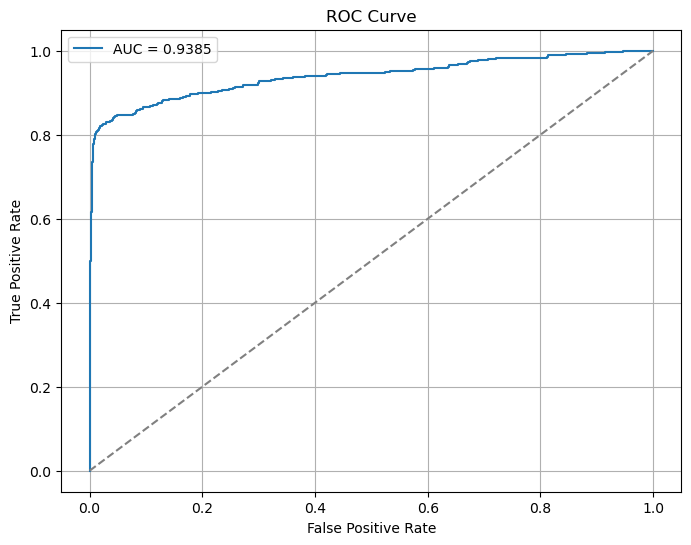

In [22]:
print(f"Optimal Threshold based on ROC: {optimal_threshold:.6f}")
roc_auc = roc_auc_score(actual_labels, reconstruction_errors)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


Classification Report (Autoencoder-based Anomaly Detection):
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99     11373
       Fraud       0.65      0.82      0.73       492

    accuracy                           0.97     11865
   macro avg       0.82      0.90      0.86     11865
weighted avg       0.98      0.97      0.98     11865



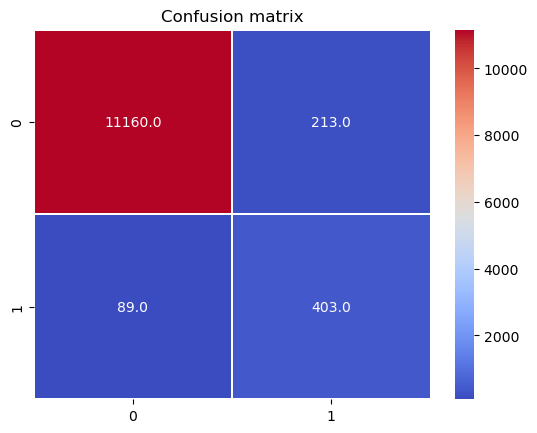

In [23]:
print("\nClassification Report (Autoencoder-based Anomaly Detection):")
print(classification_report(actual_labels, predictions, target_names=["Normal", "Fraud"]))

sns.heatmap(
    confusion_matrix(actual_labels, predictions),
    linewidths=.12,
    cmap="coolwarm",
    annot=True,
    fmt=".1f"
)
plt.title("Confusion matrix")
plt.show()

#### Choose the threshold that maximizes F1 Score

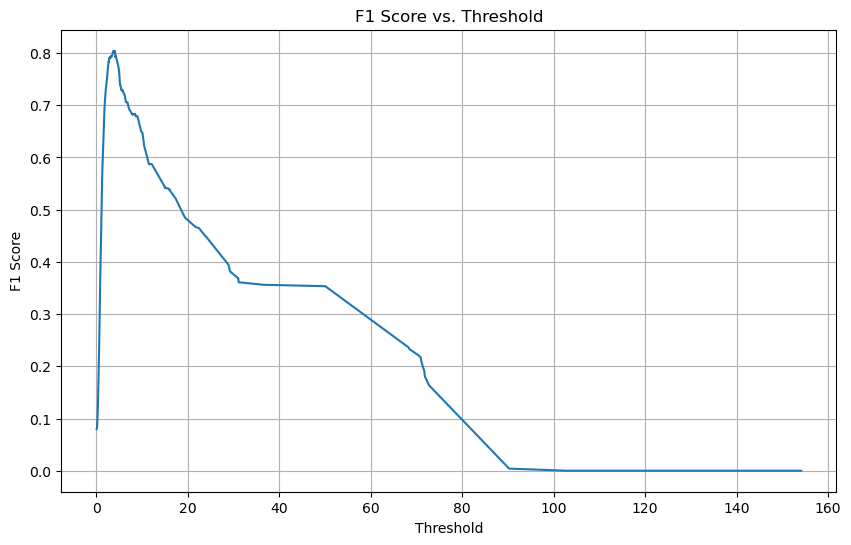

Threshold maximizing F1 Score: 4.044215


In [24]:
f1_scores = []
for t in thresholds:
    preds = (reconstruction_errors > t).astype(int)
    # find f1 score corresponding to different thresholds
    f1_scores.append(f1_score(actual_labels, preds))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.grid()
plt.show()

# Get best threshold
best_f1_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold maximizing F1 Score: {best_f1_threshold:.6f}")

predictions = (reconstruction_errors > best_f1_threshold).astype(int)


Classification Report (Autoencoder-based Anomaly Detection):
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     11373
       Fraud       0.85      0.76      0.80       492

    accuracy                           0.98     11865
   macro avg       0.92      0.88      0.90     11865
weighted avg       0.98      0.98      0.98     11865



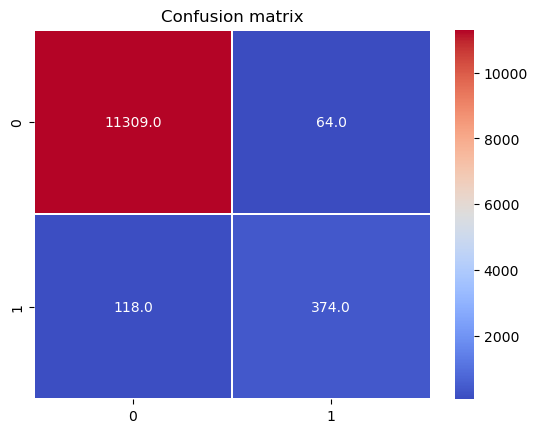

In [25]:
predictions = (reconstruction_errors > best_f1_threshold).astype(int)
print("\nClassification Report (Autoencoder-based Anomaly Detection):")
print(classification_report(actual_labels, predictions, target_names=["Normal", "Fraud"]))

sns.heatmap(
    confusion_matrix(actual_labels, predictions),
    linewidths=.12,
    cmap="coolwarm",
    annot=True,
    fmt=".1f"
)
plt.title("Confusion matrix")
plt.show()

- Precision = 0.85 → When the model predicts fraud, it's correct 85% of the time. 
- Recall = 0.76 → The model catches 76% of actual frauds. 
- F1-score = 0.80 → A balanced harmonic mean of precision and recall

## Visualize the Encoded (latent) Space

In [32]:
# Get the latent (encoded) representations
latent_reps = []
actual_labels = []

model.eval()
with torch.no_grad():
    for X,y in test_loader:
        X, y = X.to(device), y.to(device)
        # find the latent representation
        encoded = model.encoder(X)
        # print(encoded)
        latent_reps.append(encoded.cpu().numpy())
        actual_labels.extend(y.cpu().numpy())

latent_reps = np.concatenate(latent_reps)
actual_labels = np.array(actual_labels)

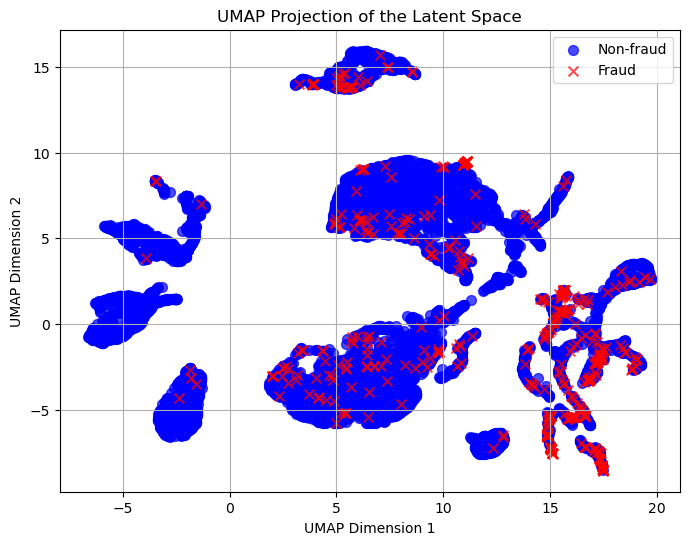

In [36]:
reducer= umap.UMAP(n_components=2, random_state=42)
latent_umap= reducer.fit_transform(latent_reps)

# Plot the UMAP projection:
plt.figure(figsize=(8, 6))
# Different markers or colors for fraud vs. non-fraud
for label, marker, color in zip([0, 1], ['o', 'x'], ['blue', 'red']):
    indices = np.where(actual_labels == label)
    plt.scatter(latent_umap[indices, 0], latent_umap[indices, 1],
                marker=marker, color=color,
                label='Non-fraud' if label == 0 else 'Fraud', alpha=0.7, s=50)
    
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP Projection of the Latent Space")
plt.legend()
plt.grid(True)
plt.show()

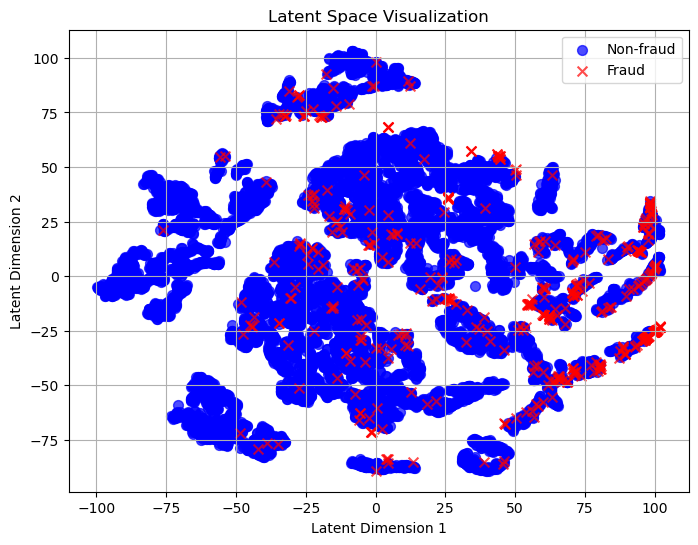

In [37]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(latent_reps)

# Plot the 2D latent space with colored labels
plt.figure(figsize=(8, 6))
# Use different markers or colors for fraud vs. non-fraud
for label, marker, color in zip([0, 1], ['o', 'x'], ['blue', 'red']):
    indices = np.where(actual_labels == label)
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], marker=marker, color=color,
                label='Non-fraud' if label == 0 else 'Fraud', alpha=0.7, s=50)
    
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# latent_2d = latent_reps

# plt.figure(figsize=(10, 6))
# # Color-code the points: different color for fraud vs non-fraud.
# for label, marker, color in zip([0, 1], ['o', 'x'], ['blue', 'red']):
#     indices = np.where(y_test == label)
#     plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1], 
#                 marker=marker, color=color, label='Non-fraud' if label == 0 else 'Fraud',
#                 alpha=0.7, s=60)